__LIBRERIAS__

In [1]:
# Librerias generales
import pandas as pd
import numpy as np
import seaborn as sns 
import glob
from scipy import linalg
import random

# Librerias para graficar
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import colors
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

# Sklearn
from sklearn.impute import KNNImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score 
from sklearn.decomposition import PCA

__IMPORTAR MÓDULOS CREADOS POR NOSOTROS__

In [2]:
import funciones as fn #funciones es el nombre del script dnd hemos creado las funciones

__CARGA DE DATOS__

In [3]:
path_dataset1 = '..\\datosTransformados\\'
lista = ['accesos','actividades', 'conocimientos', 'cursos', 'cursos_en_programas', 'itinerarios', 'notas_cursos', 'plantas', 'programas', 'roles', 'tutores_perfil', 'usuarios']

# Creamos un diccionario en blanco con los nombres de la lista como keys
dfs = {}
for i in lista:
    dfs[i] = ''

# get data file names
filenames = glob.glob(path_dataset1 + "*.csv")

# cargar dfs en el diccionario 
for i, valuei in enumerate(lista):
    for j, filename in enumerate(filenames):
        if i==j:
            dfs[valuei] = pd.read_csv(filename, index_col= [0])
    
# separar los keys del diccionario en df diferentes (con su nombre)
for i in dfs.keys():
    globals()['%s' % i.replace(" ", "_").lower()] = dfs[i]

In [4]:
#antes de empezar, ponemos una semilla para que cada vez que se ejecute el script salgan los mismos resultados
SEED = 4901
random.seed(SEED)

__CREACIÓN VARIABLES NUMÉRICAS__

In [5]:
#Seleccionar user_id y mdl_user_id
usuarios_clustering = usuarios.loc[:, ['user_id','mdl_user_id']]

#Numero de cursos realizados por usuario
num_cursos = notas_cursos.groupby('user_id').agg(num_cursos=('course_name','count')).reset_index()

#Nota media por usuario en los cursos realizados
nota_media_cursos = notas_cursos.groupby('user_id').agg(nota_media_curso=('grade','mean')).reset_index()

#Numero de actividades realizados por usuario
num_actividades = actividades.groupby('mdl_user_id').agg(num_actividades=('actividad_name','count')).reset_index()

#Nota media por usuario en las actividades realizadas
nota_media_actividades = actividades.groupby('mdl_user_id').agg(nota_media_actividades=('grade','mean')).reset_index()

#Numero de programas realizados por usuario
num_programas = itinerarios.groupby('user_id').agg(num_programas=('program_name','count')).reset_index()

#Media de frecuencia de acceso al mes por usuario
pre_num_accesos = accesos["timestamp"].str.split(expand=True)##Separar timestamp para obtener frecuencia de acceso mensual
pre_num_accesos.columns = ['fecha', 'tiempo']#renombrar columnas

pre_num_accesos =  pre_num_accesos["fecha"].str.split('-',expand=True)#separar la fecha en año-mes-dia
pre_num_accesos.columns = ['año', 'mes', 'dia']#renombrar las columnas

num_accesos = pd.concat([accesos, pre_num_accesos], axis=1)#juntar tablas
num_accesos.loc[:, ['mdl_user_id','user_id','año','mes','dia']]#seleccionar las columnas necesarias para el clustering

frecuencia_acceso_mensual = num_accesos.groupby(['user_id','mes']).agg(frecuencia_acceso_mensual=('dia','count')).reset_index()

frecuencia_media_acceso_mensual= frecuencia_acceso_mensual.groupby('user_id').agg(frecuencia_media_acceso_mensual=('frecuencia_acceso_mensual','mean')).reset_index()

__CREACIÓN DE LA TABLA PARA EL CLUSTERING__

In [6]:
#Se inserta la nota media de los cursos a la tabla de usuarios que contiene el idioma , mdl_user_id y user_id

usuarios_clustering = usuarios_clustering.merge(nota_media_cursos, on="user_id", how = "right") 
usuarios_clustering = usuarios_clustering.dropna()#las 3 instancias que no tienen un idiomas asociado ni un usuario de mudle fuera(si no tiene usuario de mudle no ha podido realizar cursos)

In [7]:
#A la tabla anterior se le añade la informacion de la cantidad de cursos realizados

usuarios_clustering = usuarios_clustering.merge(num_cursos, on="user_id", how = "left") 

In [8]:
#A la tabla anterior se le añade la informacion de la cantidad de actividades realizadas

usuarios_clustering = usuarios_clustering.merge(num_actividades, on="mdl_user_id", how = "right") 
usuarios_clustering = usuarios_clustering.dropna()#existe un porcentaje pequeño de usuarios que no han realizado actividades. Por lo tanto, como no aporta valor a laclusterizacion se eliminan(hay q tener en cuenta que la base de datos original dispone de muy pocos datos y ademas datos bastante pobres)

In [9]:
#A la tabla anterior se le añade la informacion de la nota media de las actividades realizadas

usuarios_clustering = usuarios_clustering.merge(nota_media_actividades, on="mdl_user_id", how = "left")
usuarios_clustering.isnull().sum() * 100 / len(usuarios_clustering)#existe un porcentaje muy muy pequeño(3%) de usuarios que no tienen nota media.

#Se utiliza knn para imputar dichos valores, puesto que no se ve oportuno eliminarlos directamente

# Construimos el modelo
imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Ajustamos el modelo e imputamos los missing values
imputer.fit(usuarios_clustering[["nota_media_actividades"]])
usuarios_clustering["nota_media_actividades"] = imputer.transform(usuarios_clustering[["nota_media_actividades"]]).ravel()

In [10]:
#A la tabla anterior se le añade la informacion de la cantidad de programas realizadas

usuarios_clustering = usuarios_clustering.merge(num_programas, on="user_id", how = "left") #planta_name(key value) para introducir columna planta_id

In [11]:
#A la tabla anterior se le añade la informacion de la frecuencia media de acceso mensual por usuario

usuarios_clustering = usuarios_clustering.merge(frecuencia_media_acceso_mensual, on="user_id", how = "left") 
usuarios_clustering.isnull().sum() * 100 / len(usuarios_clustering)#se observa que el 10%de los usuarios no tienen apuntado la frecuencia de acceso. 
#Por tanto, se les asignara un valor utilizando la funcion knn (identificar los registros más similares al que presenta los valores nulos y asignarle la media de sus vecinos)

# Ajustamos el modelo previamente creado e imputamos los missing values
imputer.fit(usuarios_clustering[["frecuencia_media_acceso_mensual"]])
usuarios_clustering["frecuencia_media_acceso_mensual"] = imputer.transform(usuarios_clustering[["frecuencia_media_acceso_mensual"]]).ravel()

In [12]:
#Observar que todos los valores estan correctos para comenzar con el proceso de la clusterizacion
usuarios_clustering[usuarios_clustering.isnull().any(1)]#se observa q todo se encuentra como debe sin ningun missing

,user_id,mdl_user_id,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual


In [13]:
usuarios_clustering.head()#se muestra la tabla definitiva para el proceso de clusterizacion

,user_id,mdl_user_id,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual
0,3.0,13.0,0.666667,15.0,3,10.000000,3,1.000000
1,4.0,14.0,4.091000,10.0,46,7.882088,3,3.435001
2,5.0,15.0,2.222222,9.0,44,8.575606,2,3.435001
3,7.0,18.0,3.858000,5.0,44,8.031091,1,3.435001
4,8.0,19.0,2.914000,5.0,39,8.286821,1,3.435001


In [14]:
#se guarda este dataframe que sera tambien utilizado en el apartado de la modelizacion
path_dataset2 = '..\\datosTransformados\\datamining_modelado\\' # ruta donde se van a guardar los datos 
fn.convertir_csv(usuarios_clustering, 'datamining_modelados.csv',path_dataset = path_dataset2)

# CLUSTERING

__DATA CLEANING__

In [15]:
user_mdl_id=usuarios_clustering[['user_id','mdl_user_id']]#guardar en otra variable los datos de user_id y mdl_user_id
usuarios_clustering = usuarios_clustering.drop(['user_id','mdl_user_id'], axis=1)#df para utilizar en el clustering

In [16]:
usuarios_clustering.describe()#se observa rapidamente la estadisticas principales del dataset
#Las estadisticas anteriores muestran algunas discrepancias en las variables puesto que el maximo se desvia mucho de la media.

,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,4.112720,14.895954,16.364162,8.763272,1.641618,3.435001
std,2.996642,17.025994,9.981977,1.500478,2.832310,3.961339
min,0.000000,1.000000,2.000000,1.660000,1.000000,1.000000
25%,2.527111,6.000000,10.000000,8.542500,1.000000,1.500000
50%,3.097222,12.000000,15.000000,9.214000,1.000000,2.000000
75%,5.272222,18.000000,21.000000,9.682000,1.000000,3.435001
max,9.976667,191.000000,59.000000,10.000000,35.000000,39.636364


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 432x288 with 0 Axes>

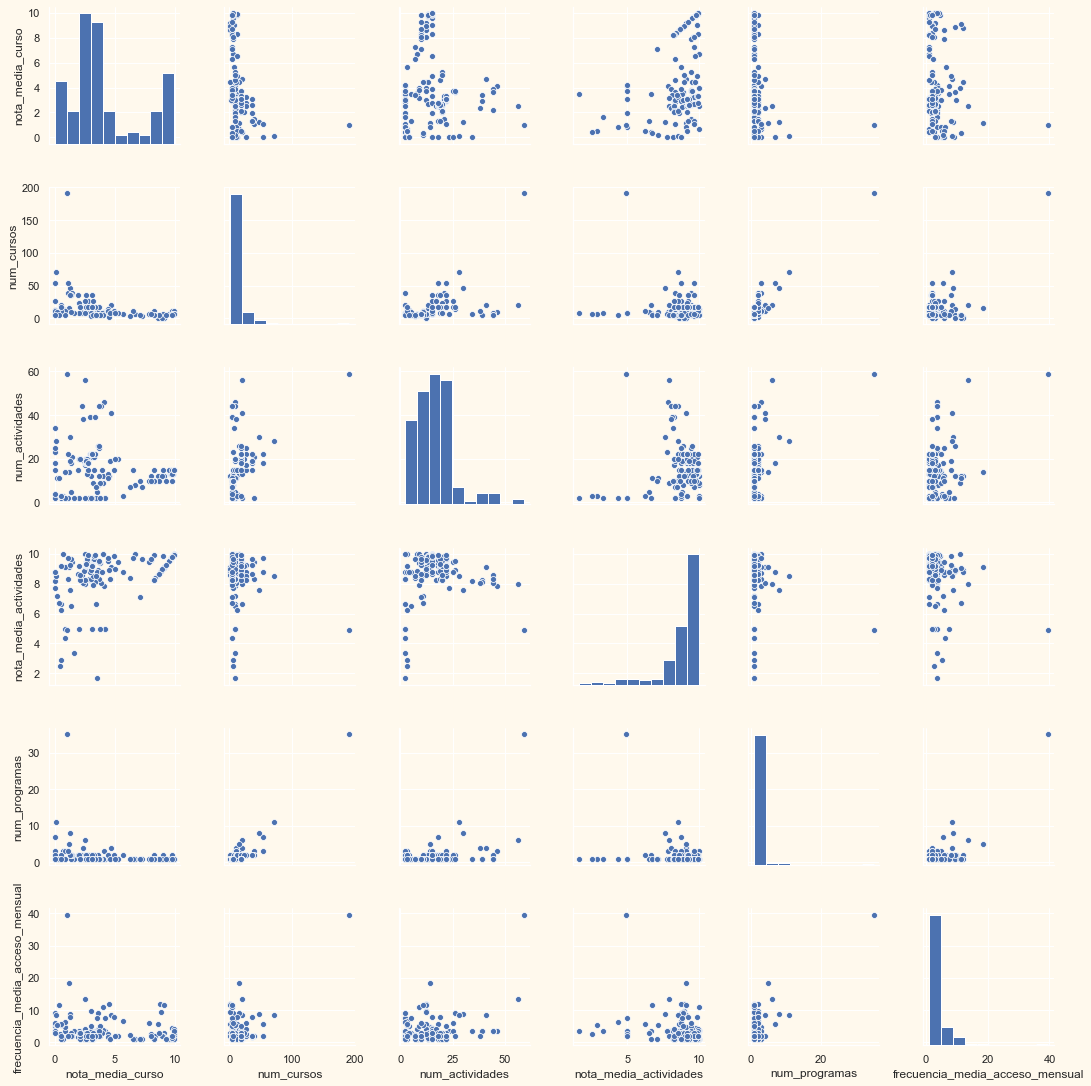

In [17]:
#Para ello, hay que echar un vistazo a la vision más amplia de los datos. Se trazan algunas de las características seleccionadas.

#Seleccionando colores
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Trazar las siguientes características
To_Plot = [ "nota_media_curso", "num_cursos", "num_actividades", "nota_media_actividades", "num_programas", "frecuencia_media_acceso_mensual"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(usuarios_clustering[To_Plot],palette= (["#682F2F","#F3AB60"]))
plt.show()

In [18]:
#Dropping the outliers by setting a cap on Age and income. 
usuarios_clustering = usuarios_clustering[(usuarios_clustering["num_actividades"]<55)]
usuarios_clustering = usuarios_clustering[(usuarios_clustering["num_programas"]<25)]
print("The total number of data-points after removing the outliers are:", len(usuarios_clustering))

The total number of data-points after removing the outliers are: 171


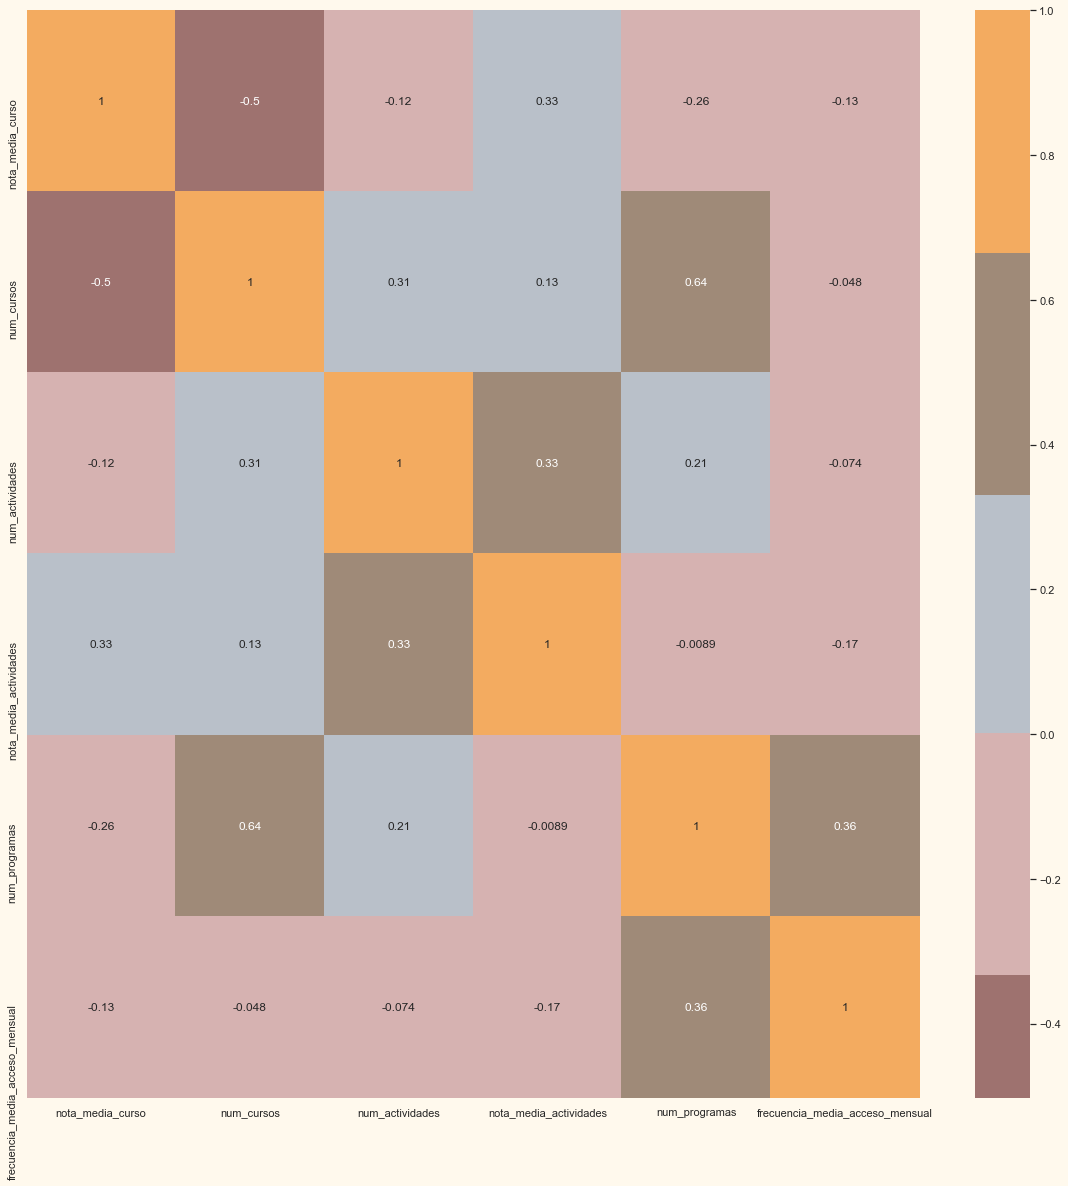

In [19]:
#Matriz de correlacion
corrmat= usuarios_clustering.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

__PREPOCESAMIENTO DE DATOS__

In [20]:
# PASO1- Escalado de las características utilizando el escalador estándar

#Creando una copia del dataframe
df_copy = usuarios_clustering.copy()

#Escalar los datos
sc = StandardScaler()
xx_scaled = sc.fit_transform(df_copy)
scaled_df_copy = pd.DataFrame(xx_scaled)
print("Todas las columnas estan ahora escaladas")

Todas las columnas estan ahora escaladas


In [21]:
# PASO2- Creación de un marco de datos subconjunto para la reducción de dimensionalidad

# Se usaran los datos escalados para reducir la dimensionalidad
print("Marco de datos que se utilizará para la modelización posterior:")
scaled_df_copy.head()

Marco de datos que se utilizará para la modelización posterior:


,0,1,2,3,4,5
0,-1.160561,0.112095,-1.438809,0.820336,1.333663,-0.793064
1,-0.016522,-0.367112,3.363534,-0.616023,1.333663,0.099308
2,-0.640864,-0.462954,3.140169,-0.145682,0.489010,0.099308
3,-0.094365,-0.846320,3.140169,-0.514970,-0.355643,0.099308
4,-0.409747,-0.846320,2.581757,-0.341535,-0.355643,0.099308


#### DIMENSIONALITY REDUCTION  

In [22]:
scaled_df_copy

,0,1,2,3,4,5
0,-1.160561,0.112095,-1.438809,0.820336,1.333663,-0.793064
1,-0.016522,-0.367112,3.363534,-0.616023,1.333663,0.099308
2,-0.640864,-0.462954,3.140169,-0.145682,0.489010,0.099308
3,-0.094365,-0.846320,3.140169,-0.514970,-0.355643,0.099308
4,-0.409747,-0.846320,2.581757,-0.341535,-0.355643,0.099308
...,...,...,...,...,...,...
166,-0.348349,0.399620,0.683157,0.341077,-0.355643,-0.793064
167,-0.357629,0.399620,0.683157,0.284561,-0.355643,-0.793064
168,-0.519663,0.399620,0.348109,0.349668,-0.355643,-0.426587
169,-0.463053,0.399620,0.236427,0.763367,-0.355643,-0.426587


In [23]:
#Iniciando PCA para reducir las dimensiones; características a 3pca = PCA(n_components=3)
pca = PCA(n_components=3)
pca.fit(scaled_df_copy)
PCA_df_copy = pd.DataFrame(pca.transform(scaled_df_copy), columns=(["col1","col2", "col3"]))
PCA_df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,171.0,5.129101e-17,1.461609,-1.873119,-0.882540,0.214558,0.335247,9.183125
col2,171.0,2.428207e-16,1.236582,-1.282310,-0.828323,-0.516872,0.487764,4.227615
col3,171.0,-9.479097e-17,1.017649,-2.038568,-0.661220,-0.263109,0.583232,4.657902


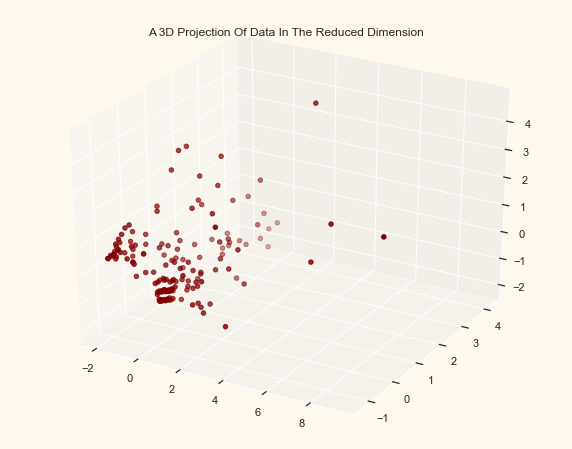

In [24]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_df_copy["col1"]
y =PCA_df_copy["col2"]
z =PCA_df_copy["col3"]
#Plotear
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

__MODELO CLUSTERING__

For n_clusters = 2 The average silhouette_score is : 0.3682083050811371
For n_clusters = 3 The average silhouette_score is : 0.444666861707517
For n_clusters = 4 The average silhouette_score is : 0.48779881514959333
For n_clusters = 5 The average silhouette_score is : 0.5042045911337446
For n_clusters = 6 The average silhouette_score is : 0.4806586696862024
For n_clusters = 7 The average silhouette_score is : 0.48811406535096685
For n_clusters = 8 The average silhouette_score is : 0.49321135521566006
For n_clusters = 9 The average silhouette_score is : 0.4488432541489805
For n_clusters = 10 The average silhouette_score is : 0.4418984515089481
For n_clusters = 11 The average silhouette_score is : 0.41657001535740534
For n_clusters = 12 The average silhouette_score is : 0.4727837091350146


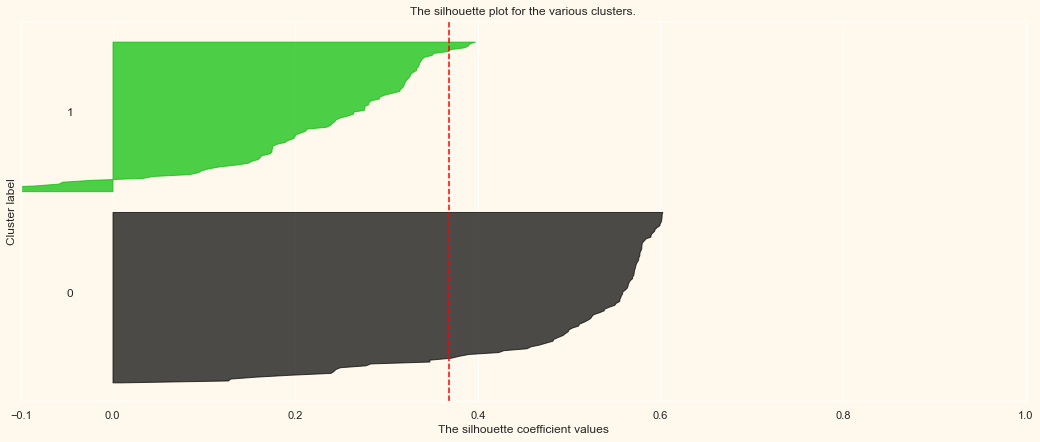

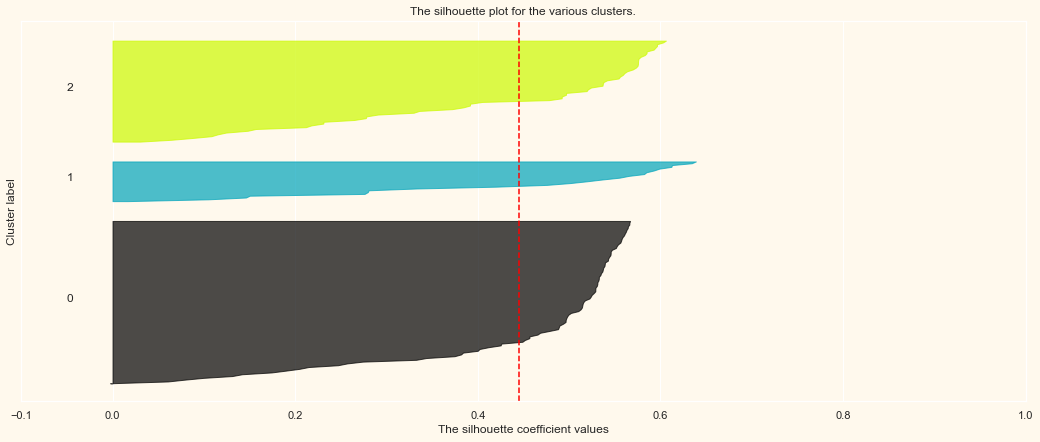

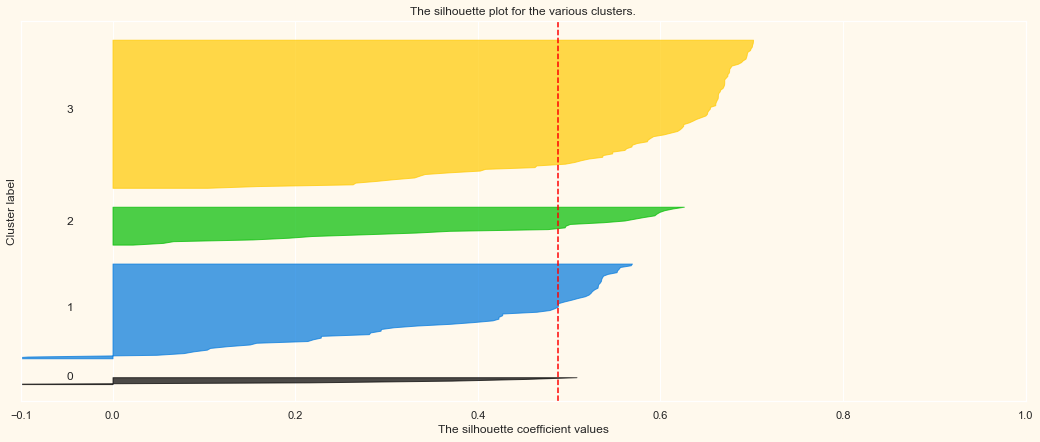

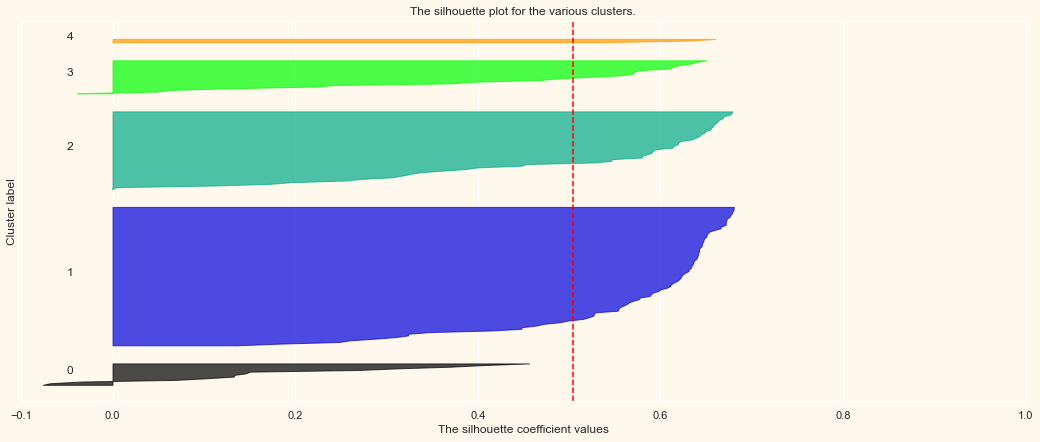

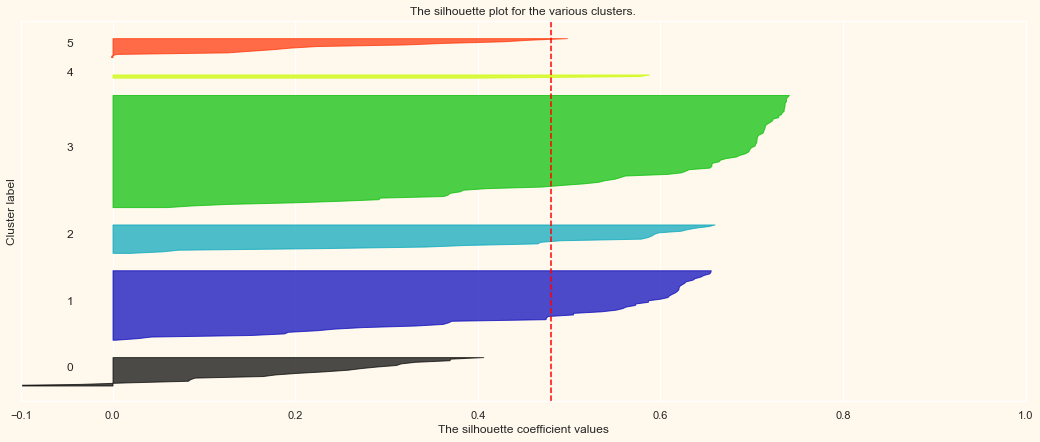

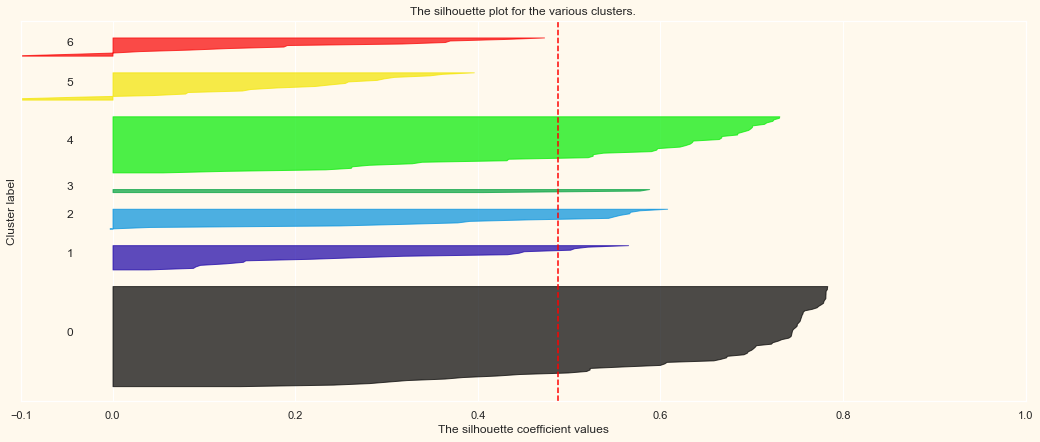

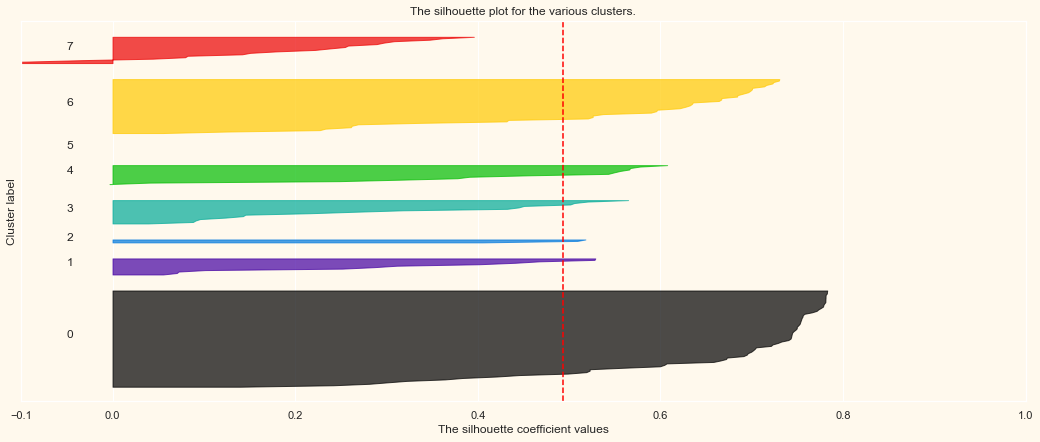

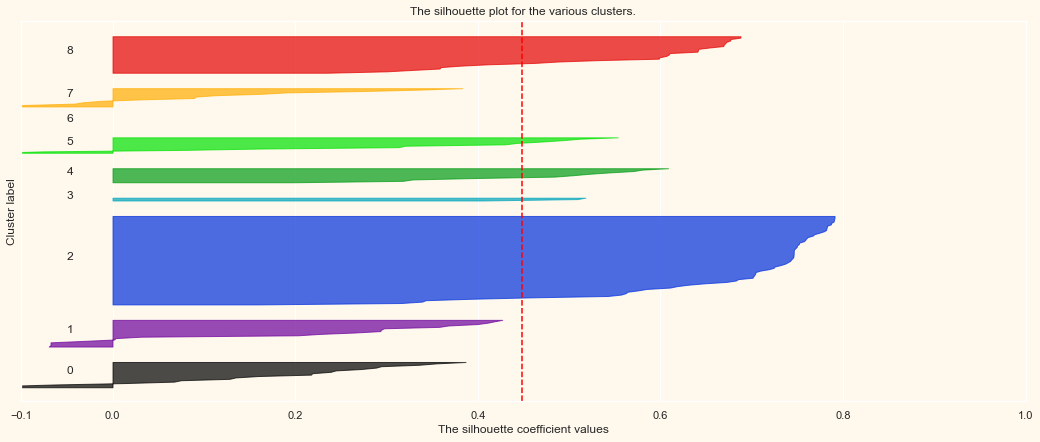

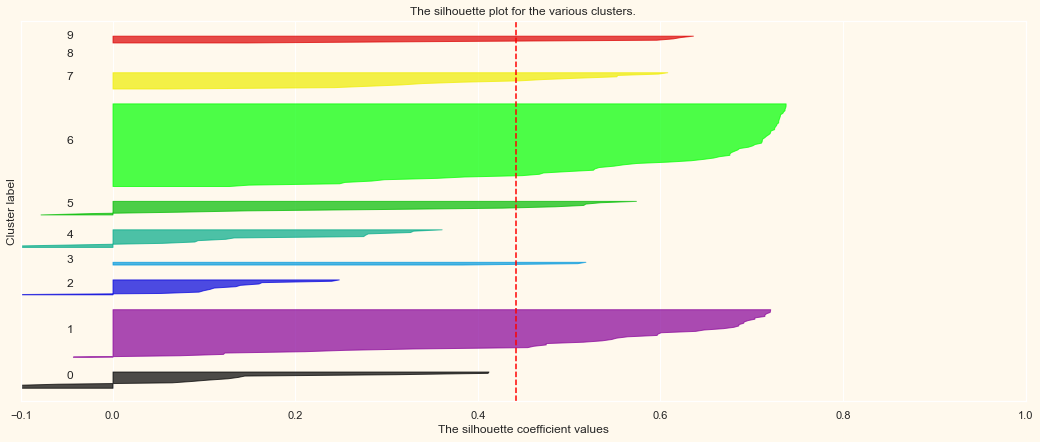

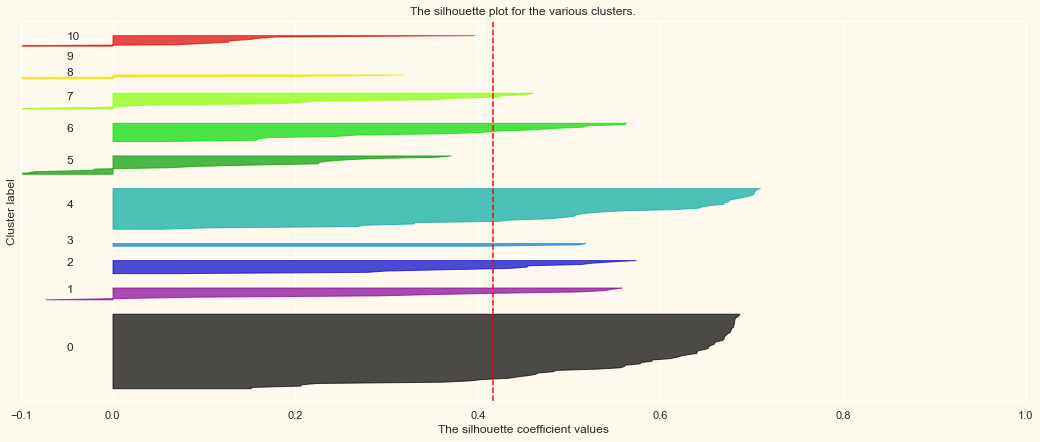

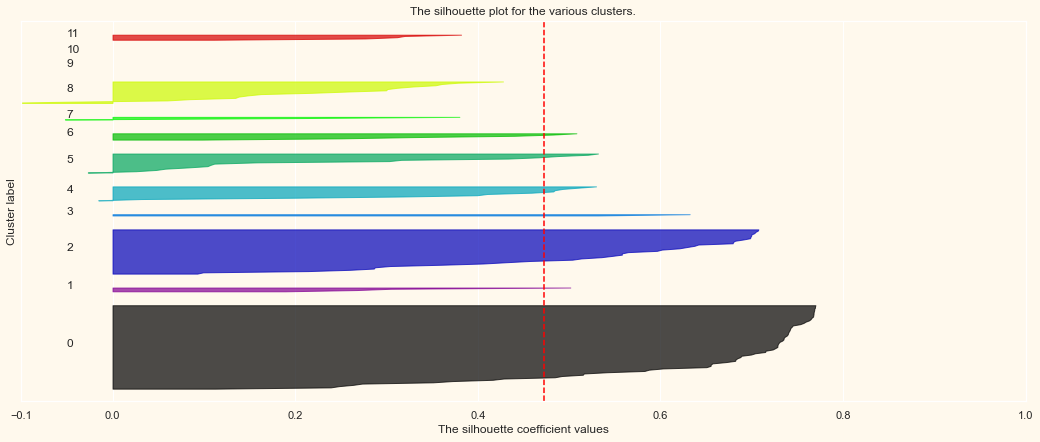

In [25]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10,11,12]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(PCA_df_copy) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, random_state=SEED)
    cluster_labels=clusterer.fit_predict(PCA_df_copy)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(PCA_df_copy, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(PCA_df_copy, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


### K-MEANS 

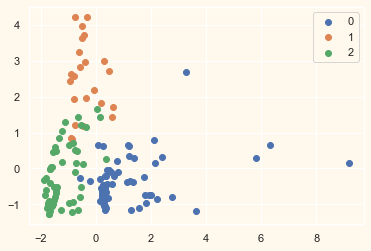

In [26]:
#3 CLUSTERES

pca = PCA(3)
 
#Transform the data
df = pca.fit_transform(scaled_df_copy)

KM_5_clusters = KMeans(n_clusters=3, init='k-means++', random_state=SEED)

label = KM_5_clusters.fit_predict(PCA_df_copy) # inicializar y ajustar el modelo K-Means

#Añadiendo la columna de los clusters al df original
usuarios_kmeans5 = usuarios_clustering.copy()
usuarios_kmeans5["Cluster"]= label

 
#Getting unique labels
u_labels5 = np.unique(label)

# Getting the cluster centers
C5 = KM_5_clusters.cluster_centers_

#plotting the results:
for i in u_labels5:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [27]:
### Obtener numero de instancias para cada cluster
KM_clust_sizes = usuarios_kmeans5.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,91
1,23
2,57


In [28]:
##Juntar en el dataframe de los kmeans 3 con los usuarios respectivos
kmeans5_clustering = pd.concat([user_mdl_id, usuarios_kmeans5], axis=1)#se añaden las dos columnas (usuario y mdl_user_id)
kmeans5_clustering

,user_id,mdl_user_id,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual,Cluster
0,3.0,13.0,0.666667,15.0,3.0,10.000000,3.0,1.000000,0.0
1,4.0,14.0,4.091000,10.0,46.0,7.882088,3.0,3.435001,0.0
2,5.0,15.0,2.222222,9.0,44.0,8.575606,2.0,3.435001,0.0
3,7.0,18.0,3.858000,5.0,44.0,8.031091,1.0,3.435001,0.0
4,8.0,19.0,2.914000,5.0,39.0,8.286821,1.0,3.435001,0.0
...,...,...,...,...,...,...,...,...,...
168,418.0,439.0,3.097778,18.0,22.0,9.293333,1.0,1.000000,0.0
169,419.0,440.0,3.070000,18.0,22.0,9.210000,1.0,1.000000,0.0
170,420.0,441.0,2.585000,18.0,19.0,9.306000,1.0,2.000000,0.0
171,421.0,442.0,2.754444,18.0,18.0,9.916000,1.0,2.000000,0.0


### AGLOMERATIVE CLUSTERING 

In [29]:
PCA_df_copy

,col1,col2,col3
0,0.747729,0.219569,-0.457563
1,1.574454,-1.100832,0.476735
2,1.255193,-1.153843,0.047894
3,0.309723,-1.041679,-0.020778
4,0.283042,-0.787641,-0.126540
...,...,...,...
166,0.245877,-0.884818,-0.828936
167,0.250642,-0.843667,-0.850367
168,0.292963,-0.520346,-0.647466
169,0.229617,-0.762173,-0.497896


In [30]:
#Iniciando el modelo Aglomerative clustering
AC = AgglomerativeClustering(n_clusters=4)
# fit el modelo y predecir los clusteres
yhat_AC = AC.fit_predict(PCA_df_copy)
PCA_df_copy["Clusters"] = yhat_AC
#Añadiendo la columna de los clusters al df original
usuarios_clustering["Clusters"]= yhat_AC

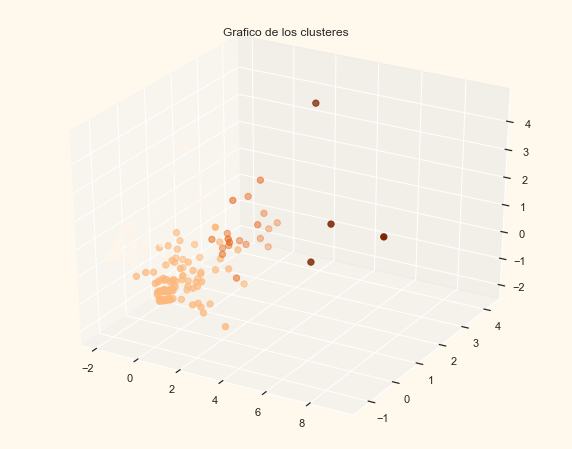

In [31]:
#Para examinar los grupos formados echemos un vistazo a la distribución 3D de los grupos.

#Ploteando clusteres
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=usuarios_clustering["Clusters"], marker='o', cmap = 'Oranges' )
ax.set_title("Grafico de los clusteres")
plt.show()

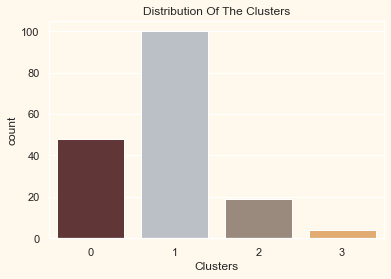

,KM_size
Clusters,
0,48
1,100
2,19
3,4


In [32]:
#En primer lugar, echemos un vistazo a la distribución grupal de clustring

#Plotear distribucion cluster
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=usuarios_clustering["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

#Mirar los usuarios en cada cluster
aglomerative_sizes = usuarios_clustering.groupby('Clusters').size().to_frame()
aglomerative_sizes.columns = ["KM_size"]
aglomerative_sizes

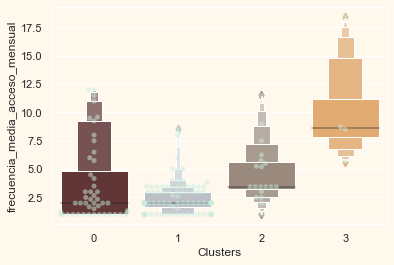

In [33]:
#Comparacion clusteres en cuanto a la media de acceso por usuario

plt.figure()
pl=sns.swarmplot(x=usuarios_clustering["Clusters"], y=usuarios_clustering["frecuencia_media_acceso_mensual"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=usuarios_clustering["Clusters"], y=usuarios_clustering["frecuencia_media_acceso_mensual"], palette=pal)
plt.show()

In [34]:
usuarios_clustering

,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual,Clusters
0,0.666667,15.0,3,10.000000,3,1.000000,1
1,4.091000,10.0,46,7.882088,3,3.435001,1
2,2.222222,9.0,44,8.575606,2,3.435001,1
3,3.858000,5.0,44,8.031091,1,3.435001,1
4,2.914000,5.0,39,8.286821,1,3.435001,1
...,...,...,...,...,...,...,...
168,3.097778,18.0,22,9.293333,1,1.000000,1
169,3.070000,18.0,22,9.210000,1,1.000000,1
170,2.585000,18.0,19,9.306000,1,2.000000,1
171,2.754444,18.0,18,9.916000,1,2.000000,1


In [35]:
mean_aglo_clustering = usuarios_clustering.groupby('Clusters').mean()#media de caracteristicas por cluster
mean_aglo_clustering

,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual
Clusters,,,,,,
0,8.282014,5.687500,12.187500,9.394460,1.166667,3.630903
1,2.767549,17.290000,19.770000,9.159720,1.340000,2.378787
2,1.641542,9.210526,3.368421,5.378818,1.157895,4.608421
3,0.634206,47.000000,22.500000,8.514322,7.750000,10.331349


In [36]:
aglo_clustering = pd.concat([user_mdl_id, usuarios_clustering], axis=1)#se añaden las dos columnas (usuario y mdl_user_id)
aglo_clustering.head()

,user_id,mdl_user_id,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual,Clusters
0,3.0,13.0,0.666667,15.0,3.0,10.000000,3.0,1.000000,1.0
1,4.0,14.0,4.091000,10.0,46.0,7.882088,3.0,3.435001,1.0
2,5.0,15.0,2.222222,9.0,44.0,8.575606,2.0,3.435001,1.0
3,7.0,18.0,3.858000,5.0,44.0,8.031091,1.0,3.435001,1.0
4,8.0,19.0,2.914000,5.0,39.0,8.286821,1.0,3.435001,1.0


__EVALUACIÓN DE ALGORITMOS__

<ipython-input-37-212222c934a9>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
<ipython-input-37-212222c934a9>:16: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig1.tight_layout()


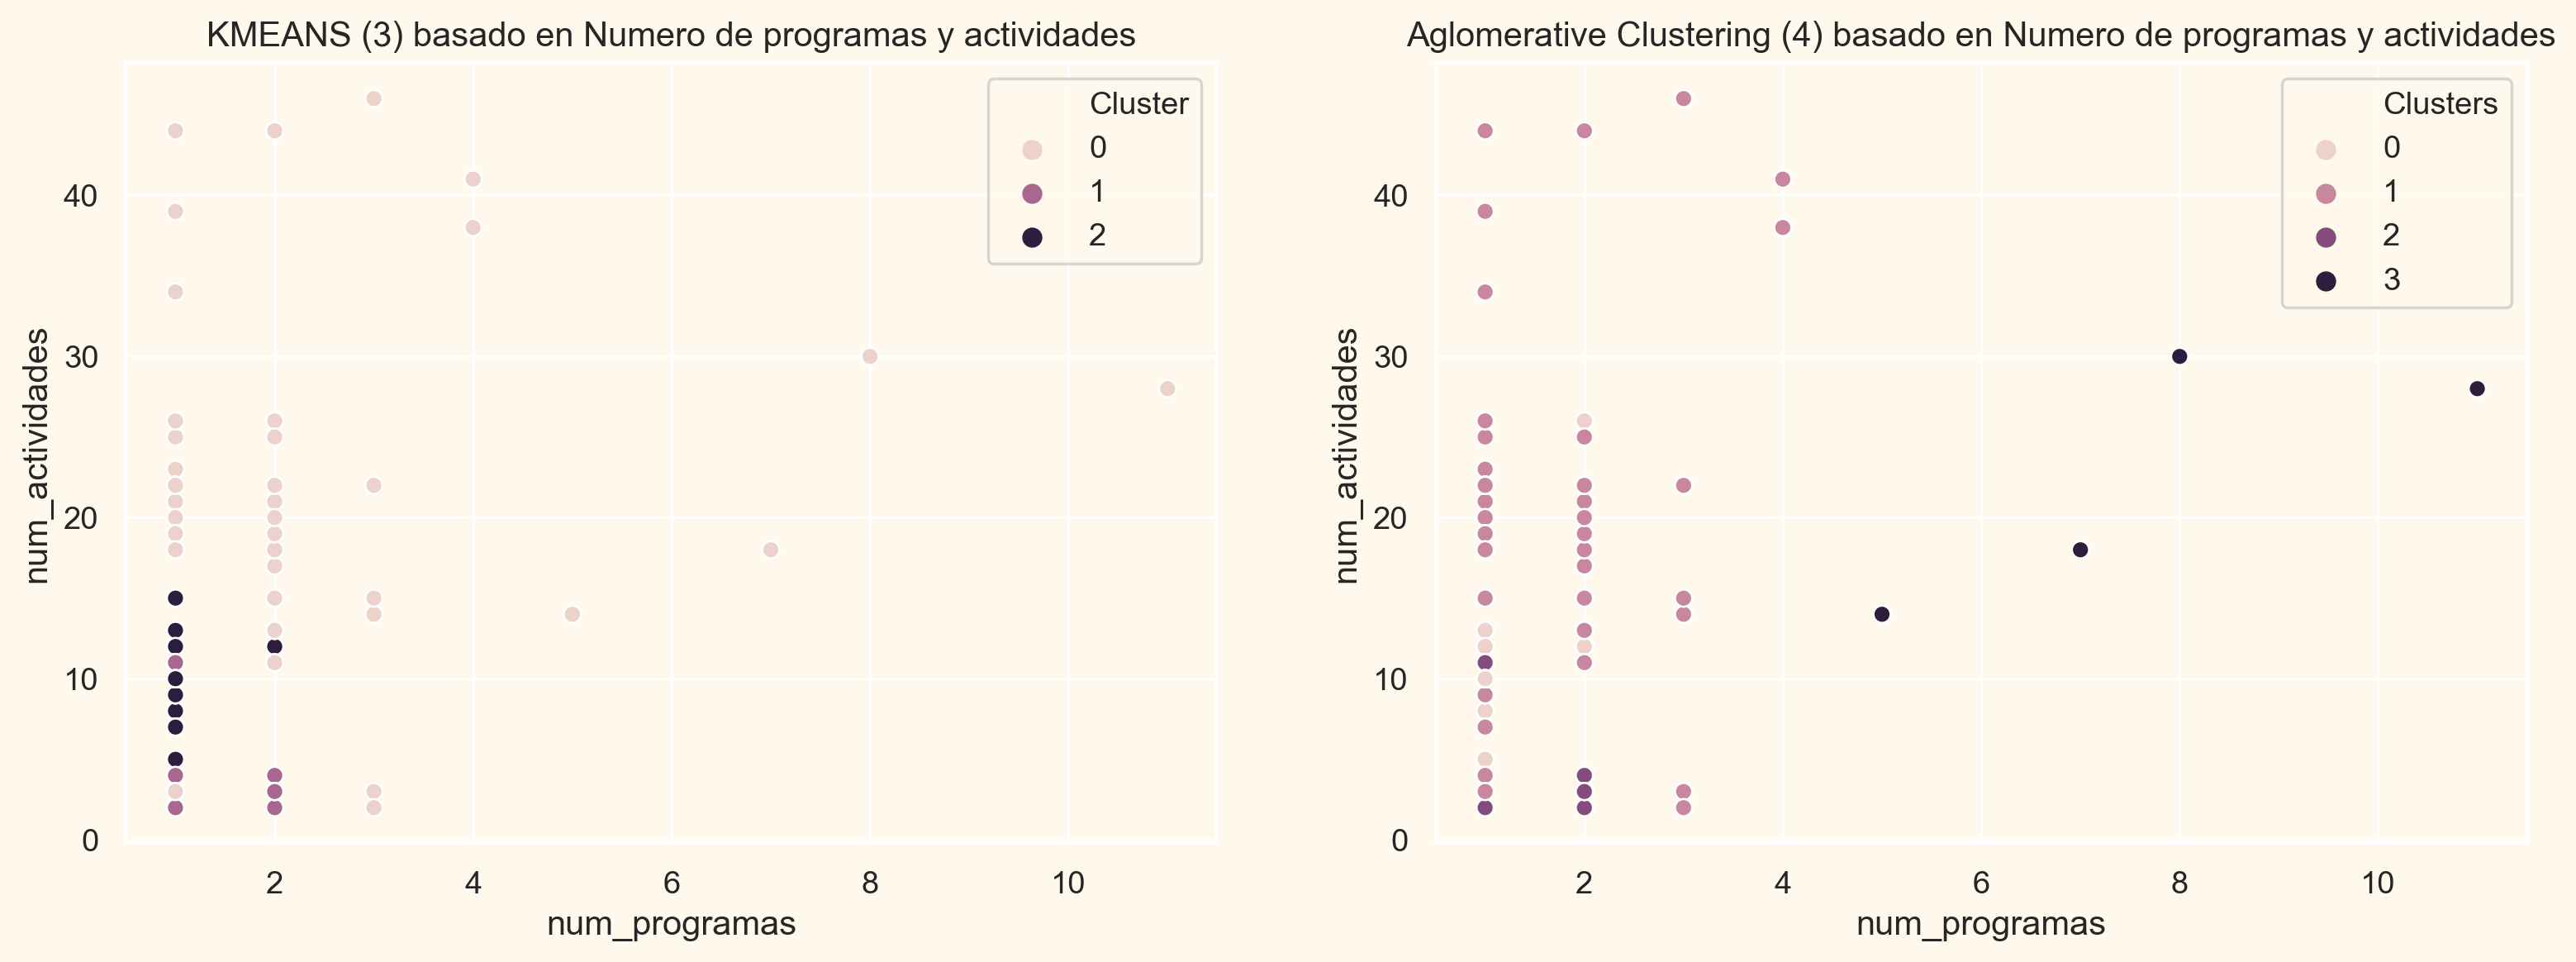

In [37]:
#En primer lugar, echemos un vistazo a la distribución grupal de clustering

fig1, ax1 = plt.subplots(1,2)

sns.scatterplot(ax = ax1[0], data = usuarios_kmeans5,x=usuarios_kmeans5["num_programas"], y=usuarios_kmeans5["num_actividades"],hue=usuarios_kmeans5["Cluster"])
sns.scatterplot(ax = ax1[1], data = aglo_clustering,x=aglo_clustering["num_programas"], y=aglo_clustering["num_actividades"],hue=aglo_clustering["Clusters"])

ax1[0].set_title("KMEANS (3) basado en Numero de programas y actividades")
ax1[1].set_title("Aglomerative Clustering (4) basado en Numero de programas y actividades")


ax1[0].legend()
ax1[1].legend()

fig1.show()
fig1.tight_layout()
fig1.set_size_inches(15,5)
fig1.set_dpi(250)

<ipython-input-38-bac9d851325e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


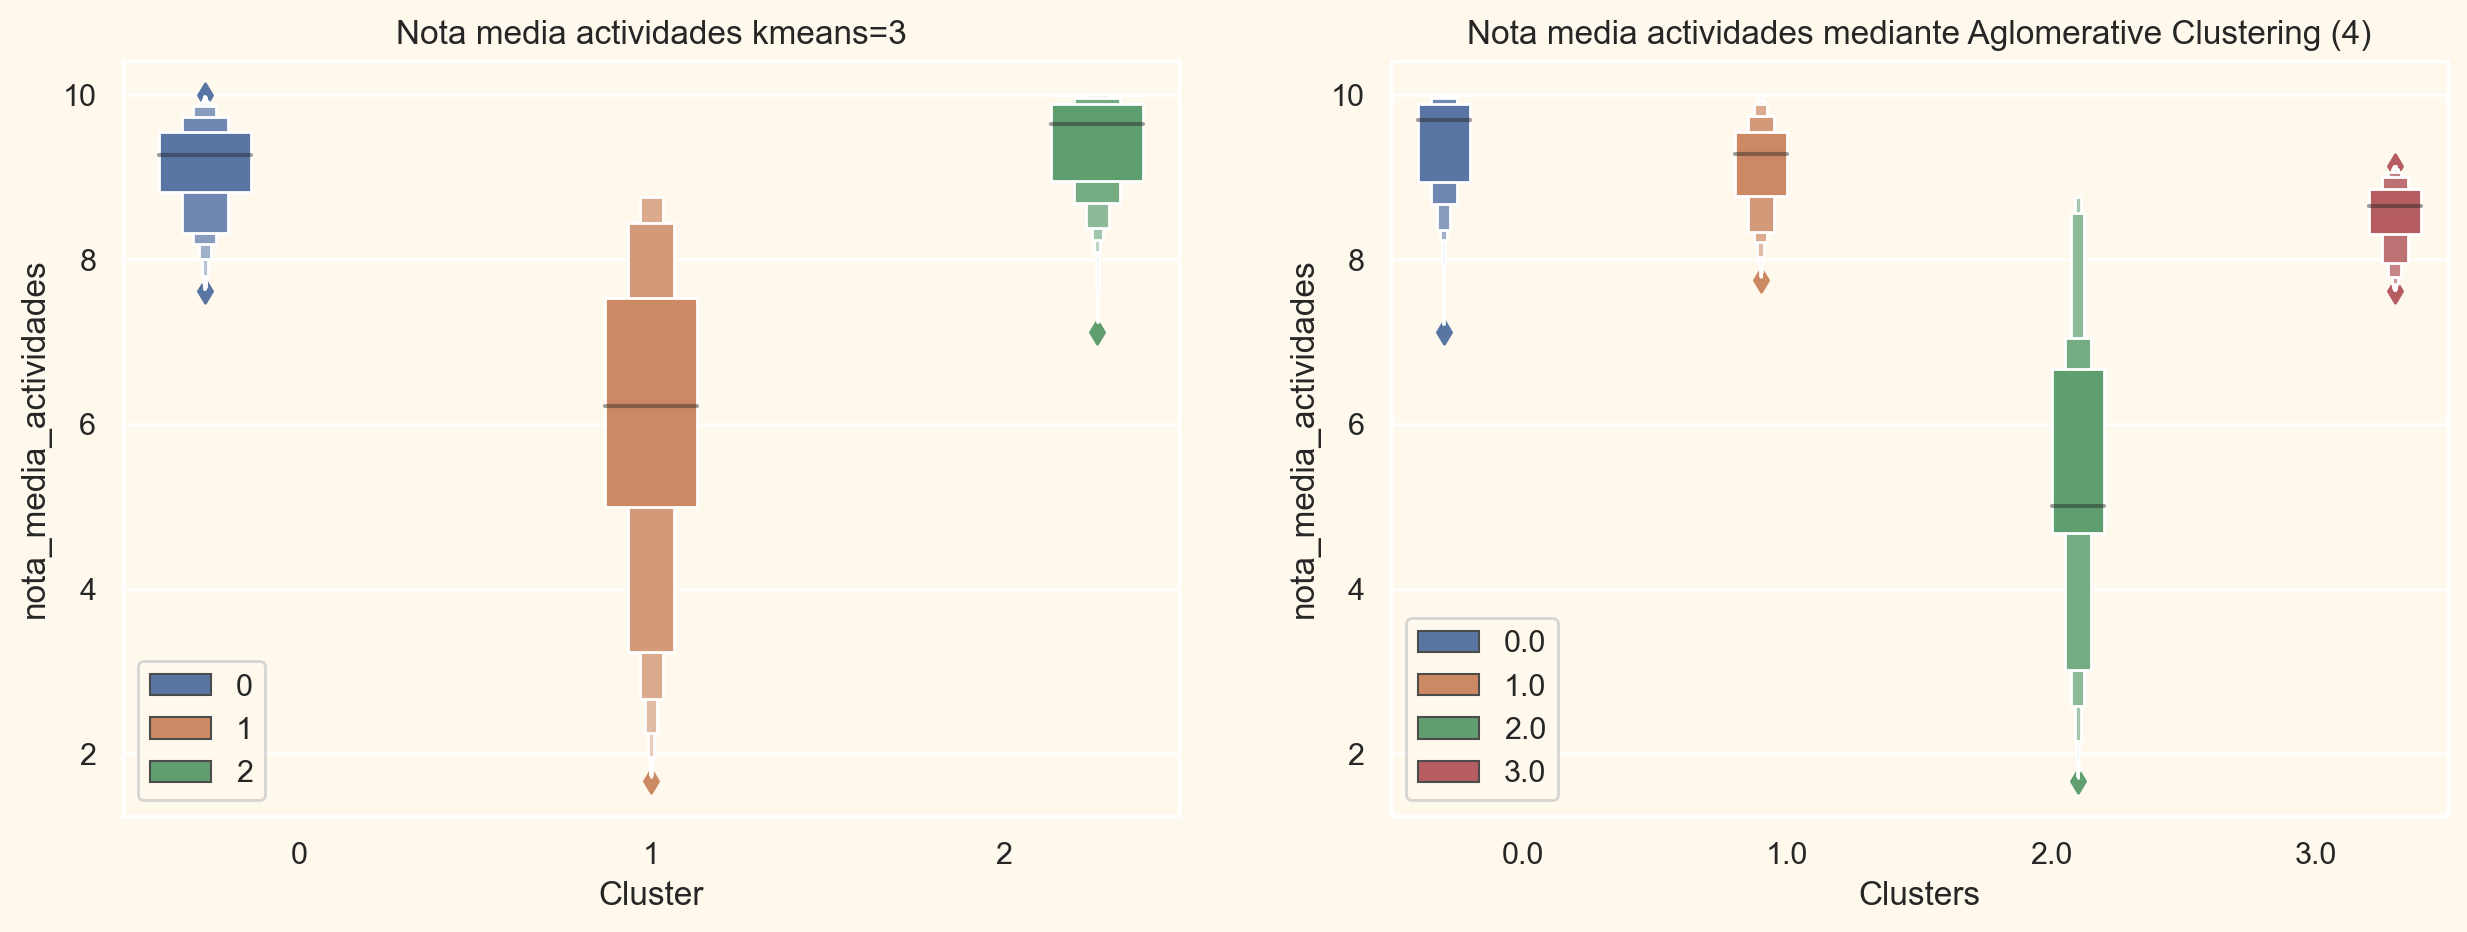

In [38]:
fig2, ax2 = plt.subplots(1,2)

sns.boxenplot(ax = ax2[0], data = usuarios_kmeans5,x=usuarios_kmeans5["Cluster"], y=usuarios_kmeans5["nota_media_actividades"],hue=usuarios_kmeans5["Cluster"])
sns.boxenplot(ax = ax2[1], data = aglo_clustering,x=aglo_clustering["Clusters"], y=aglo_clustering["nota_media_actividades"],hue=aglo_clustering["Clusters"])

ax2[0].set_title("Nota media actividades kmeans=3")
ax2[1].set_title("Nota media actividades mediante Aglomerative Clustering (4)")


ax2[0].legend()
ax2[1].legend()

fig2.show()
fig2.set_size_inches(15,5)
fig2.set_dpi(200)

### CONCLUSION 